# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [267]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from xgboost import plot_importance
import numpy as np
import sklearn.metrics as metrics
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)

In [90]:
# import data
df = pd.read_csv('student_data.csv')

#  Check data head
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,-2,-2,316,316,316,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [140]:
df.astype(int)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAY,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay
0,350000,37,-2,-2,-2,-2,-2,-2,316,316,316,466,466,316,316,316,466,466,316,316,0,0,0,0,0,0,-12
1,50000,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0,12897,12668,12446,38222,38094,6
2,50000,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0,0,0,0,-22,-70,-6
3,20000,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0,13196,13420,12668,11668,10668,2
4,110000,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0,101982,106457,104729,103064,101412,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,50000,24,0,0,0,-2,-2,-2,12806,13490,0,0,0,0,7522,0,0,0,0,0,1,0,0,0,0,5968,-6
23995,250000,44,-1,-1,-1,-1,-1,-1,6826,3900,4482,43546,38051,576,3924,4482,43676,38166,576,2389,1,0,-115,-130,0,-24,-6
23996,50000,26,2,0,0,2,2,2,41827,42650,45930,44891,47654,48721,1800,4000,0,3500,2000,0,1,46721,44154,44891,41930,40850,8
23997,110000,38,0,0,0,0,0,0,195437,176420,63142,39854,9293,-1288,5000,10000,5048,2000,39958,52000,1,-41246,7293,34806,53142,171420,0


In [151]:
df.dtypes

LIMIT_BAL       float64
PAY_0           float64
PAY_2           float64
PAY_3           float64
PAY_4           float64
PAY_5           float64
PAY_6           float64
BILL_AMT1       float64
BILL_AMT2       float64
BILL_AMT3       float64
BILL_AMT4       float64
BILL_AMT5       float64
BILL_AMT6       float64
PAY_AMT1        float64
PAY_AMT2        float64
PAY_AMT3        float64
PAY_AMT4        float64
PAY_AMT5        float64
PAY_AMT6        float64
DEFAULT_PAY     float64
amount_owed6    float64
amount_owed5    float64
amount_owed4    float64
amount_owed3    float64
amount_owed2    float64
late_pay        float64
dtype: object

In [166]:
df.shape

(23985, 26)

## 1. Data Cleaning

In [91]:
#Drop ID 
df.drop(columns= 'ID', axis=1, inplace=True)

In [92]:
#Rename Default Pay
df.rename(columns = {'default payment next month': 'DEFAULT_PAY'}, inplace=True)

In [93]:
#Cleaning education
df.loc[(df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 'EDUCATION'] = 4

In [94]:
#Removing outliers found in EDA
df.loc[df['BILL_AMT1'] > 800000] = np.nan
df.loc[df['BILL_AMT2'] > 800000] = np.nan
df.loc[df['BILL_AMT3'] > 1000000] = np.nan
df.loc[df['BILL_AMT4'] > 800000] = np.nan
df.loc[df['BILL_AMT5'] > 800000] = np.nan
df.loc[df['PAY_AMT6'] > 500000] = np.nan
df.loc[df['PAY_AMT5'] > 350000] = np.nan
df.loc[df['PAY_AMT4'] > 400000] = np.nan
df.loc[df['PAY_AMT3'] > 600000] = np.nan
df.loc[df['PAY_AMT2'] > 750000] = np.nan
df.loc[df['PAY_AMT1'] > 400000] = np.nan
df.loc[df['BILL_AMT6'] > 600000] = np.nan

df.dropna(inplace = True)

In [95]:
#Cleaning marriange
df.MARRIAGE.replace(0.0, 3.0, inplace =True)

## 2. EDA

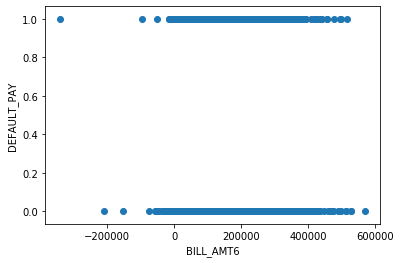

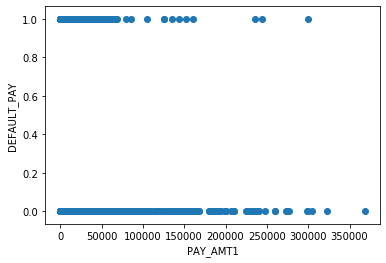

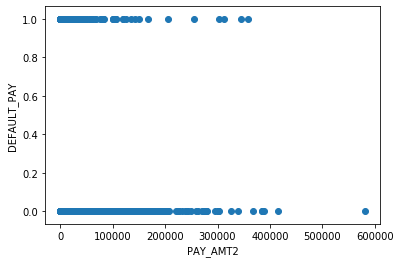

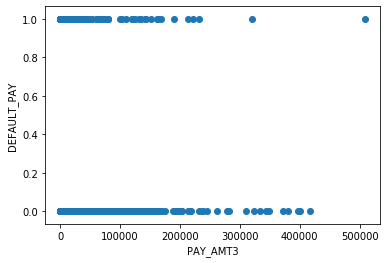

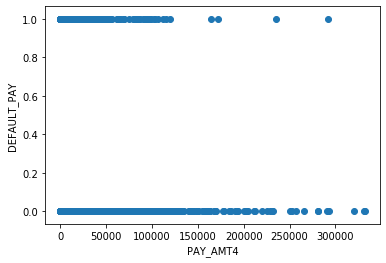

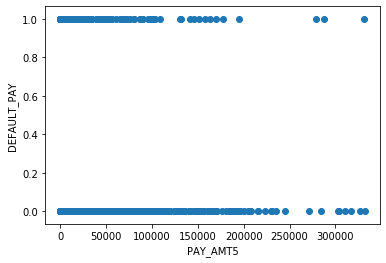

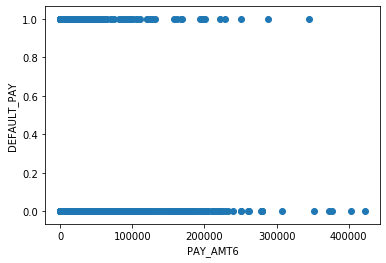

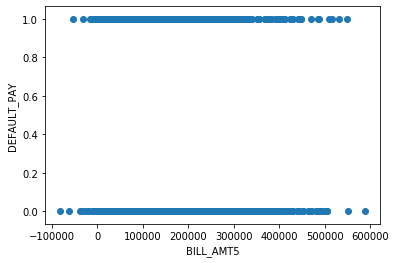

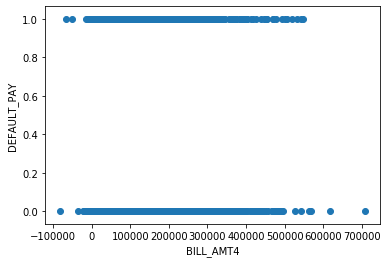

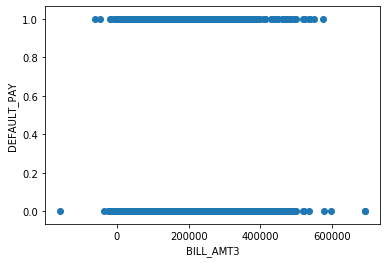

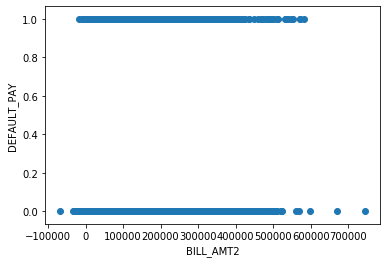

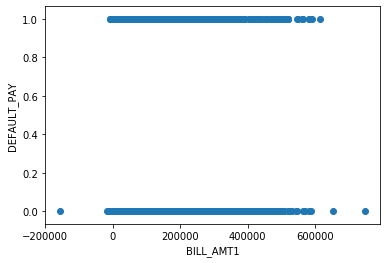

In [96]:
#Finding outliers 
variable = ['BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1'] 

def bill_pay_amt(df, var):
    df = df.copy()
    
    plt.scatter(df[var], df['DEFAULT_PAY'])
    plt.ylabel('DEFAULT_PAY')
    plt.xlabel(var)
    plt.show()
    
for var in variable:
    bill_pay_amt(df, var)

(array([4.076e+03, 6.617e+03, 5.167e+03, 3.845e+03, 2.092e+03, 1.493e+03,
        5.220e+02, 1.370e+02, 3.100e+01, 5.000e+00]),
 array([21. , 26.8, 32.6, 38.4, 44.2, 50. , 55.8, 61.6, 67.4, 73.2, 79. ]),
 <a list of 10 Patch objects>)

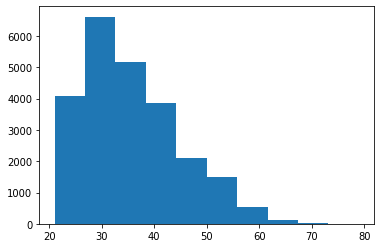

In [97]:
#understanding Age
plt.hist(df['AGE'])

In [98]:
df['AGE'].describe()

count    23985.000000
mean        35.522243
std          9.254577
min         21.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         79.000000
Name: AGE, dtype: float64

In [99]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,23985.0,167636.009172,129608.115770,10000.0,50000.0,140000.0,240000.0,800000.0
SEX,23985.0,1.603586,0.489163,1.0,1.0,2.0,2.0,2.0
EDUCATION,23985.0,1.845945,0.746287,1.0,1.0,2.0,2.0,4.0
MARRIAGE,23985.0,1.556098,0.521821,1.0,1.0,2.0,2.0,3.0
AGE,23985.0,35.522243,9.254577,21.0,28.0,34.0,42.0,79.0
PAY_0,23985.0,-0.014843,1.121064,-2.0,-1.0,0.0,0.0,8.0
PAY_2,23985.0,-0.134626,1.193264,-2.0,-1.0,0.0,0.0,8.0
PAY_3,23985.0,-0.165520,1.193658,-2.0,-1.0,0.0,0.0,8.0
PAY_4,23985.0,-0.216969,1.168952,-2.0,-1.0,0.0,0.0,8.0
PAY_5,23985.0,-0.261163,1.133185,-2.0,-1.0,0.0,0.0,8.0


In [100]:
#Checking default of gender
gender = df.groupby(['SEX', 'DEFAULT_PAY']).size().unstack(1)
gender

DEFAULT_PAY,0.0,1.0
SEX,,
1.0,7211,2297
2.0,11467,3010


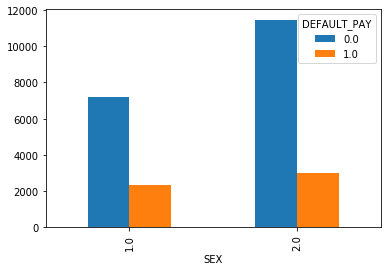

In [101]:
gender.plot(kind='bar')

In [102]:
gender['percent'] = (gender[1]/(gender[0] + gender[1])) 
gender

DEFAULT_PAY,0.0,1.0,percent
SEX,,,
1.0,7211,2297,0.241586
2.0,11467,3010,0.207916


In [103]:
def corrl(Col1, Col2):
    res = df.groupby([Col1, Col2]).size().unstack()
    res['percent'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [104]:
corrl('EDUCATION', 'DEFAULT_PAY')

DEFAULT_PAY,0.0,1.0,percent
EDUCATION,,,
1.0,6820,1616,0.191560
2.0,8528,2655,0.237414
3.0,2979,1012,0.253571
4.0,351,24,0.064000


In [105]:
corrl('MARRIAGE', 'DEFAULT_PAY')

DEFAULT_PAY,0.0,1.0,percent
MARRIAGE,,,
1.0,8393,2559,0.233656
2.0,10052,2676,0.210245
3.0,233,72,0.236066


In [106]:
corrl('AGE', 'DEFAULT_PAY').sort_values('AGE')

DEFAULT_PAY,0.0,1.0,percent
AGE,,,
21.0,39.0,12.0,0.235294
22.0,325.0,142.0,0.304069
23.0,537.0,189.0,0.260331
24.0,657.0,232.0,0.260967
25.0,702.0,236.0,0.251599
26.0,797.0,208.0,0.206965
27.0,947.0,259.0,0.214760
28.0,910.0,229.0,0.201054
29.0,1023.0,255.0,0.199531


## 3. Feature Engineering

In [107]:
# New Feature amount owed.
df['amount_owed6'] = df['BILL_AMT6']- df['PAY_AMT5']
df['amount_owed5'] = df['BILL_AMT5']- df['PAY_AMT4']
df['amount_owed4'] = df['BILL_AMT4']- df['PAY_AMT3']
df['amount_owed3'] = df['BILL_AMT3']- df['PAY_AMT2']
df['amount_owed2'] = df['BILL_AMT2']- df['PAY_AMT1']

In [108]:
# New feature Late Pay
df['late_pay'] = df["PAY_0"] + df["PAY_2"]+ df["PAY_3"]+ df["PAY_4"]+ df["PAY_5"]+ df["PAY_6"]

## 4. Feature Selection

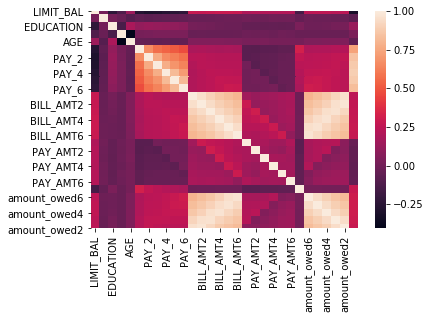

In [127]:
corr = df.corr()
sns.heatmap(corr)

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

### KNN

In [110]:
k_scores = []

k_range = list(range(1, 12))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    y_pred = knn.predict(X_test)
    
    test_f1 = f1_score(y_test, y_pred)
    
    k_scores.append(test_f1)
    print(k_scores)





[0.3698891860909438]
[0.3698891860909438, 0.27827050997782704]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219, 0.35614973262032085]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 0.33315363881401616, 0.40302743614001896, 0.3502945902517407, 0.3984413054067219, 0.35614973262032085, 0.3959595959595959]
[0.3698891860909438, 0.27827050997782704, 0.40611353711790393, 

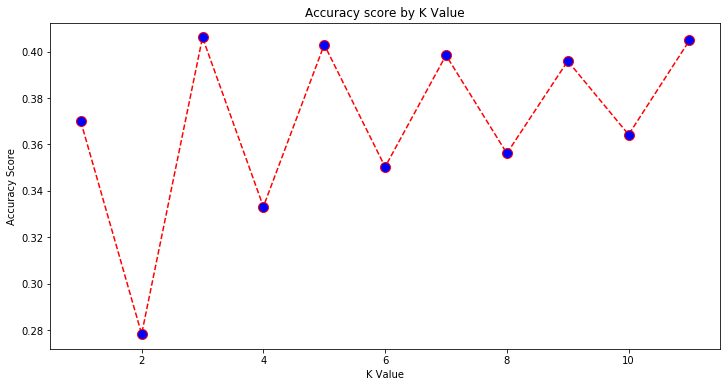

In [111]:
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

#### Standard Scaler(KNN)

In [24]:
#Split
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [30]:
# Standard Scaler(KNN)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [32]:
y_pred = knn.predict(X_test)

In [34]:
accuracy_score(y_test, y_pred)

0.5591128897782225

In [35]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.36104398260028997

#### For MinMaxScaler(KNN)

In [113]:
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [114]:
minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

In [115]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, y_train)
y_pred =knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.7732199433049858

In [116]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.40611353711790393

### Logistic Regression

In [117]:
logreg = LogisticRegression(class_weight = 'balanced')

In [118]:
logreg.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
y_predlogreg = logreg.predict(X_test)

In [121]:
accuracy_score(y_test, y_predlogreg)

0.6878439219609805

In [122]:
test_f1 = f1_score(y_test, y_predlogreg)
test_f1

0.4645308924485126

### Bagging Classifier

In [154]:
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [155]:
bag = BaggingClassifier(random_state = 1, max_features = 25, n_estimators = 15, max_samples = 100)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=25, max_samples=100, n_estimators=15,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

In [156]:
pred = bag.predict(X_test)
f1_score(y_test, pred)

0.4560413728255759

#### Bagging with Gridsearch

In [235]:
params = {'max_samples' : (60, 70, 80, 90, 100),
          'n_estimators' : (10, 12, 15, 17),
          
         }

In [236]:
gsearchbag = GridSearchCV(
    estimator = bag,
    param_grid = params,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    iid = False,
    cv = 5)

In [237]:
bag.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__base_estimator', 'estimator__bootstrap', 'estimator__bootstrap_features', 'estimator__max_features', 'estimator__max_samples', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [238]:
gsearchbag.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=25, max_samples=100,
                                         n_estimators=15, n_jobs=None,
                                         oob_score=False, random_state=1,
                                         verbose=0, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'max_samples': (60, 70, 80, 90, 100),
                         'n_estimators': (10, 12, 15, 17)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [239]:
gsearchbag.best_params_

{'max_samples': 90, 'n_estimators': 17}

In [211]:
gsearchbag.best_score_

0.2019896607327485

In [240]:
preds = gsearchbag.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.803735
F1: 0.448195


### XGBOOST 

In [241]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',)
clf_xgb.fit(X_train, y_train)
pred = clf_xgb.predict(X_test)
#learning_rate = .3, max_depth = 4, n_estimators = 30, colsample_bytree = .3, min_child_weight = 4, max_delta_step = 1

In [242]:
f1_score(y_test, pred)

0.462531017369727

#### XGBOOST GRID SEARCH

In [261]:
xgb.XGBClassifier()

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', verbose=1, n_jobs=-1)
param_dist = {'max_depth': (1, 2, 3),
              'learning_rate': (.1, .5, .9, 1.1), 
             'n_estimators': (125, 150, 175),
             'min_child_weight': (1, 2, 3, 4,), 
             'max_delta_step' : (0, 1, 2)}

In [262]:
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False,
    cv=5)

gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 68.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 79.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbose=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': (0.1, 0.5, 0.9, 1.1),
                         'max_delta_step': (0, 1, 2), 'max_depth': (1, 2, 3),
                

In [263]:
gsearch1.best_params_

{'learning_rate': 0.5,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 125}

In [264]:
gsearch1.best_score_

0.4766473007722306

In [265]:
preds = gsearch1.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.811906
F1: 0.448141


### Random Forest

In [268]:
clf_cv = RandomForestClassifier(random_state=27, class_weight = 'balanced')
clf_cv.fit(X_train, y_train)
preds = clf_cv.predict(X_test)
f1_score(y_test, preds)
#n_estimators = 250, min_samples_leaf = 3, max_depth = 12, max_leaf_nodes = 225, max_features = 15, min_samples_split= 15

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.40769990128331685

In [269]:
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [270]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
f1_score(y_test, preds)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.40176817288801575

#### Random Forest GridSearch

In [273]:
clf_cv = RandomForestClassifier(random_state=27, class_weight = 'balanced')
param_dist = {
    'min_samples_split': (8, 11, 15, 20),
    'n_estimators' : (200, 250, 300),
    'min_samples_leaf' : (2, 3, 4),
    'max_depth': (9, 12, 15),
    'max_leaf_nodes': (200, 225, 250),
    'max_features' : (10, 15, 20),
    'min_samples_split' : (10, 15, 20)
    }


# n_estimators = 250, min_samples_leaf = 3, max_depth = 12, max_leaf_nodes = 225, max_features = 15, min_samples_split= 15

In [274]:
gsearchrf = GridSearchCV(
    estimator = clf_cv,
    param_grid = param_dist,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False,
    cv=5)

gsearchrf.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 72.7min


KeyboardInterrupt: 

In [ ]:
gsearchrf.best_params_

In [ ]:
gsearchrf.best_score_

In [ ]:
preds = gsearchrf.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

## 6. Model Evaluation

## 7. Final Model